In [15]:
dataname="trg-multi-7classes-10x"
class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Epithelium"]
nclasses=len(class_names)
in_channels= 3  #input channel of the data, RGB = 3



# --- training params
batch_size=256
patch_size=64 #currently, this needs to be 224 due to densenet architecture
num_epochs = 100
phases = ["train","val"] #how many phases did we create databases for?
#validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up
validation_phases= [] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up    

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet
from torchsummary import summary

from albumentations import *
from albumentations.pytorch import ToTensor

import PIL
import matplotlib.pyplot as plt
import cv2

import scipy
import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

from tqdm.autonotebook import tqdm


import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
gpuid=0
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11018MB, multi_processor_count=68)


In [5]:
checkpoint = torch.load("./trg_multi_multires_latest_model.pth", map_location=device)
checkpointbest = torch.load("./trg_multi_multires_best_v1.pth", map_location=device)

In [8]:
#from torchvision.models import DenseNet
import sys
sys.path.insert(0,'/home/ltran/trg_ltran/')
from src.models.MultiResSmallNetwork import MergeSmallNetworks

In [11]:
model=MergeSmallNetworks(nclasses = nclasses, outputsize = 7 ).to(device)
#model.load_state_dict(checkpoint["model_dict"])

In [8]:
checkpointbest['best_loss_on_test']['val']

0.34111106

In [12]:
summary(model.res1,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 62, 62]             168
              ReLU-2            [-1, 6, 62, 62]               0
       BatchNorm2d-3            [-1, 6, 62, 62]              12
            Conv2d-4            [-1, 8, 30, 30]             440
              ReLU-5            [-1, 8, 30, 30]               0
       BatchNorm2d-6            [-1, 8, 30, 30]              16
            Conv2d-7            [-1, 8, 14, 14]             584
              ReLU-8            [-1, 8, 14, 14]               0
       BatchNorm2d-9            [-1, 8, 14, 14]              16
           Conv2d-10              [-1, 8, 6, 6]             584
             ReLU-11              [-1, 8, 6, 6]               0
      BatchNorm2d-12              [-1, 8, 6, 6]              16
           Conv2d-13              [-1, 8, 2, 2]             584
             ReLU-14              [-1, 

In [10]:
#summary(model.res1.encoder,input_size=(3,64,64))

In [13]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgres1.shape[0]
        
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgres1=db.root.imgres1
            self.imgres2=db.root.imgres2
            
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            imgres1 = self.imgres1[index,:,:,:]
            imgres2 = self.imgres2[index,:,:,:]
            
            label = self.labels[index]
        
        
        imgres1_new = imgres1
        imgres2_new = imgres2
        
        if self.img_transform:
            #img_new = self.img_transform(image=img)['image']
            trans = self.img_transform(image=imgres1,imgres2=imgres2)
            imgres1_new = trans['image']
            imgres2_new = trans['imgres2']

        return imgres1_new, imgres2_new, label
    def __len__(self):
        return self.nitems

In [14]:
#https://github.com/albu/albumentations/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb
img_transform = Compose([
        RandomScale(scale_limit=0.1,p=.9),
        PadIfNeeded(min_height=patch_size,min_width=patch_size),        
        VerticalFlip(p=.5),
        HorizontalFlip(p=.5),
        #Blur(p=.5),
        #Downscale(p=.25, scale_min=0.64, scale_max=0.99),
        GaussNoise(p=.5, var_limit=(10.0, 50.0)),
        GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3), 
                       border_mode=cv2.BORDER_REFLECT),
        ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
        RandomBrightness(p=.5, limit=(-0.2, 0.2)),
        RandomContrast(p=.5, limit=(-0.2, 0.2)),
        RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
        MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
        HueSaturationValue(hue_shift_limit=20,sat_shift_limit=10,val_shift_limit=10,p=.9),
        Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
        CenterCrop(patch_size,patch_size),
        ToTensor()
    ], additional_targets={'imgres2':'image'})

In [17]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"../../../data/processed/{dataname}-{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")

train dataset size:	12000
val dataset size:	2400


Vein


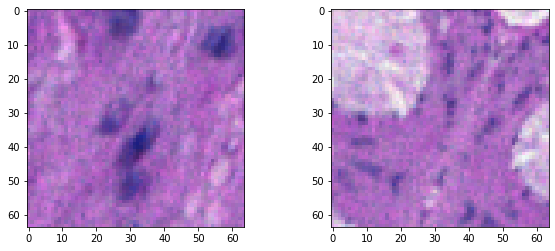

In [18]:
#visualize a single example to verify that it is correct
(imgres1,imgres2, label)=dataset["train"][0]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(imgres1.numpy(),0,-1))
ax[1].imshow(np.moveaxis(imgres2.numpy(),0,-1))


# ax[0].imshow(imgres1)
# ax[1].imshow(imgres2)


print(class_names[label])

In [19]:
optim = torch.optim.Adam(model.parameters(), weight_decay=.001) 

In [20]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class

class_weight=dataset["train"].classsizes
print(class_weight)
#class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)
class_weight = torch.from_numpy(class_weight.max()/class_weight).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight) 

[[1500 3500 1200  600 3000 1200 1000]]
tensor([[2.3333, 1.0000, 2.9167, 5.8333, 1.1667, 2.9167, 3.5000]],
       device='cuda:0')


In [21]:
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity
start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (Xres1, Xres2, label) in tqdm(enumerate(dataLoader[phase]),total=len(dataLoader[phase])): #for each of the batches
            Xres1 = Xres1.to(device)  # [Nbatch, 3, H, W]
            Xres2 = Xres2.to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...num_classes)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                
                prediction = model.dualfoward(Xres1,Xres2)  # [N, Nclass]
                #prediction = model.res1(Xres1)  # [N, Nclass]
                #prediction = model.res2(Xres2)  # [N, Nclass]
                loss = criterion(prediction, label)


                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    CM = scipy.sparse.coo_matrix((np.ones(yflat.shape[0], dtype=np.int64), (yflat, cpredflat)),
                            shape=(nclasses, nclasses), dtype=np.int64,
                            ).toarray()
                    cmatrix[phase]=cmatrix[phase]+CM
                    

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if epoch in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'num_classes': nclasses}
        torch.save(state, f"{dataname}-best.pth")
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'num_classes': nclasses}
        torch.save(state, f"{dataname}-best.pth")
        torch.save(state, f"{dataname}-latest.pth")
            
    else:
        print("")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide



1m 26s (- 141m 53s) ([1/100] 1%), train loss: 1.9008 test loss: 1.7565  **



2m 52s (- 140m 34s) ([2/100] 2%), train loss: 1.6748 test loss: 1.8724



4m 18s (- 139m 1s) ([3/100] 3%), train loss: 1.5454 test loss: 1.5618  **



5m 43s (- 137m 30s) ([4/100] 4%), train loss: 1.4676 test loss: 1.4143  **



7m 9s (- 136m 7s) ([5/100] 5%), train loss: 1.4049 test loss: 1.5052



8m 36s (- 134m 49s) ([6/100] 6%), train loss: 1.3388 test loss: 1.6309



10m 3s (- 133m 37s) ([7/100] 7%), train loss: 1.3087 test loss: 1.2764  **



11m 31s (- 132m 33s) ([8/100] 8%), train loss: 1.2728 test loss: 1.2528  **



12m 59s (- 131m 23s) ([9/100] 9%), train loss: 1.2425 test loss: 1.2760



14m 28s (- 130m 14s) ([10/100] 10%), train loss: 1.2026 test loss: 1.2118  **



15m 55s (- 128m 52s) ([11/100] 11%), train loss: 1.1939 test loss: 1.7242



17m 23s (- 127m 29s) ([12/100] 12%), train loss: 1.1608 test loss: 1.2702



18m 50s (- 126m 5s) ([13/100] 13%), train loss: 1.1416 test loss: 1.2475



20m 17s (- 124m 40s) ([14/100] 14%), train loss: 1.1428 test loss: 1.3243



21m 44s (- 123m 11s) ([15/100] 15%), train loss: 1.1193 test loss: 1.1271  **



23m 10s (- 121m 38s) ([16/100] 16%), train loss: 1.0978 test loss: 1.0916  **



24m 35s (- 120m 4s) ([17/100] 17%), train loss: 1.0971 test loss: 1.1026



26m 2s (- 118m 37s) ([18/100] 18%), train loss: 1.0979 test loss: 1.0970



27m 29s (- 117m 10s) ([19/100] 19%), train loss: 1.0975 test loss: 1.4105



28m 55s (- 115m 40s) ([20/100] 20%), train loss: 1.0685 test loss: 1.0648  **



30m 21s (- 114m 13s) ([21/100] 21%), train loss: 1.0554 test loss: 1.0700



31m 47s (- 112m 44s) ([22/100] 22%), train loss: 1.0461 test loss: 1.6210



33m 14s (- 111m 16s) ([23/100] 23%), train loss: 1.0551 test loss: 1.1106



34m 40s (- 109m 47s) ([24/100] 24%), train loss: 1.0421 test loss: 1.0908



36m 7s (- 108m 23s) ([25/100] 25%), train loss: 1.0458 test loss: 1.0733



37m 35s (- 106m 59s) ([26/100] 26%), train loss: 1.0113 test loss: 1.1165



39m 1s (- 105m 31s) ([27/100] 27%), train loss: 1.0073 test loss: 1.1824



40m 28s (- 104m 4s) ([28/100] 28%), train loss: 0.9910 test loss: 1.0300  **



41m 55s (- 102m 39s) ([29/100] 28%), train loss: 1.0014 test loss: 1.0170  **



43m 22s (- 101m 12s) ([30/100] 30%), train loss: 0.9692 test loss: 1.2419



44m 49s (- 99m 46s) ([31/100] 31%), train loss: 0.9871 test loss: 1.0172



46m 16s (- 98m 20s) ([32/100] 32%), train loss: 0.9706 test loss: 1.1440



47m 44s (- 96m 54s) ([33/100] 33%), train loss: 0.9526 test loss: 1.1199



49m 10s (- 95m 27s) ([34/100] 34%), train loss: 0.9397 test loss: 1.0337



50m 37s (- 94m 1s) ([35/100] 35%), train loss: 0.9251 test loss: 1.2589



52m 4s (- 92m 35s) ([36/100] 36%), train loss: 0.9262 test loss: 1.0046  **



53m 32s (- 91m 9s) ([37/100] 37%), train loss: 0.9241 test loss: 1.1438



54m 59s (- 89m 43s) ([38/100] 38%), train loss: 0.9099 test loss: 1.0356



56m 26s (- 88m 16s) ([39/100] 39%), train loss: 0.9054 test loss: 0.9837  **



57m 52s (- 86m 48s) ([40/100] 40%), train loss: 0.8943 test loss: 1.0807



59m 18s (- 85m 20s) ([41/100] 41%), train loss: 0.8937 test loss: 0.9440  **



60m 45s (- 83m 54s) ([42/100] 42%), train loss: 0.8884 test loss: 0.9795



62m 12s (- 82m 26s) ([43/100] 43%), train loss: 0.8802 test loss: 0.9776



63m 38s (- 80m 59s) ([44/100] 44%), train loss: 0.8698 test loss: 1.1372



65m 5s (- 79m 32s) ([45/100] 45%), train loss: 0.8687 test loss: 0.9850



66m 31s (- 78m 5s) ([46/100] 46%), train loss: 0.8564 test loss: 0.9340  **



67m 57s (- 76m 37s) ([47/100] 47%), train loss: 0.8592 test loss: 0.9934



69m 23s (- 75m 10s) ([48/100] 48%), train loss: 0.8526 test loss: 0.9302  **



70m 48s (- 73m 41s) ([49/100] 49%), train loss: 0.8465 test loss: 0.8624  **



72m 13s (- 72m 13s) ([50/100] 50%), train loss: 0.8720 test loss: 0.8893



73m 39s (- 70m 46s) ([51/100] 51%), train loss: 0.8416 test loss: 0.8281  **



75m 6s (- 69m 19s) ([52/100] 52%), train loss: 0.8212 test loss: 1.1329



76m 31s (- 67m 51s) ([53/100] 53%), train loss: 0.8232 test loss: 0.8604



77m 56s (- 66m 23s) ([54/100] 54%), train loss: 0.8002 test loss: 0.8572



79m 21s (- 64m 55s) ([55/100] 55%), train loss: 0.8050 test loss: 1.1878



80m 47s (- 63m 28s) ([56/100] 56%), train loss: 0.8077 test loss: 1.0713



82m 12s (- 62m 1s) ([57/100] 56%), train loss: 0.7792 test loss: 1.0554



83m 38s (- 60m 33s) ([58/100] 57%), train loss: 0.7886 test loss: 0.9193



85m 4s (- 59m 7s) ([59/100] 59%), train loss: 0.7984 test loss: 0.9566



86m 30s (- 57m 40s) ([60/100] 60%), train loss: 0.7841 test loss: 0.9538



87m 57s (- 56m 13s) ([61/100] 61%), train loss: 0.7632 test loss: 0.8680



89m 23s (- 54m 47s) ([62/100] 62%), train loss: 0.7711 test loss: 0.9162



90m 49s (- 53m 20s) ([63/100] 63%), train loss: 0.7622 test loss: 0.7987  **



92m 15s (- 51m 53s) ([64/100] 64%), train loss: 0.7583 test loss: 0.7911  **



93m 41s (- 50m 26s) ([65/100] 65%), train loss: 0.7491 test loss: 0.7551  **



95m 8s (- 49m 0s) ([66/100] 66%), train loss: 0.7504 test loss: 0.9730



96m 35s (- 47m 34s) ([67/100] 67%), train loss: 0.7377 test loss: 0.8412



98m 1s (- 46m 7s) ([68/100] 68%), train loss: 0.7491 test loss: 0.9138



99m 27s (- 44m 40s) ([69/100] 69%), train loss: 0.7448 test loss: 1.1781



100m 54s (- 43m 14s) ([70/100] 70%), train loss: 0.7388 test loss: 0.7797



102m 21s (- 41m 48s) ([71/100] 71%), train loss: 0.7324 test loss: 0.8689



103m 47s (- 40m 21s) ([72/100] 72%), train loss: 0.7239 test loss: 1.0035



105m 13s (- 38m 55s) ([73/100] 73%), train loss: 0.7143 test loss: 0.8117



106m 40s (- 37m 28s) ([74/100] 74%), train loss: 0.7186 test loss: 1.7752



108m 8s (- 36m 2s) ([75/100] 75%), train loss: 0.7144 test loss: 0.8040



109m 35s (- 34m 36s) ([76/100] 76%), train loss: 0.7039 test loss: 0.7161  **



111m 1s (- 33m 9s) ([77/100] 77%), train loss: 0.7043 test loss: 0.7972



112m 26s (- 31m 42s) ([78/100] 78%), train loss: 0.7096 test loss: 0.7830



113m 52s (- 30m 16s) ([79/100] 79%), train loss: 0.6873 test loss: 0.7367



115m 18s (- 28m 49s) ([80/100] 80%), train loss: 0.7082 test loss: 0.7327



116m 43s (- 27m 22s) ([81/100] 81%), train loss: 0.6952 test loss: 1.0768



118m 10s (- 25m 56s) ([82/100] 82%), train loss: 0.6775 test loss: 0.8148



119m 36s (- 24m 29s) ([83/100] 83%), train loss: 0.6904 test loss: 0.7004  **



121m 2s (- 23m 3s) ([84/100] 84%), train loss: 0.6919 test loss: 0.7335



122m 28s (- 21m 36s) ([85/100] 85%), train loss: 0.6769 test loss: 0.7117



123m 55s (- 20m 10s) ([86/100] 86%), train loss: 0.6750 test loss: 1.0077



125m 22s (- 18m 43s) ([87/100] 87%), train loss: 0.6818 test loss: 0.7966



126m 48s (- 17m 17s) ([88/100] 88%), train loss: 0.6733 test loss: 0.8706



128m 14s (- 15m 50s) ([89/100] 89%), train loss: 0.6730 test loss: 0.6893  **



129m 41s (- 14m 24s) ([90/100] 90%), train loss: 0.6603 test loss: 1.0077



131m 7s (- 12m 58s) ([91/100] 91%), train loss: 0.6700 test loss: 0.8000



132m 33s (- 11m 31s) ([92/100] 92%), train loss: 0.6699 test loss: 0.9244



133m 59s (- 10m 4s) ([93/100] 93%), train loss: 0.6487 test loss: 0.7299



135m 25s (- 8m 38s) ([94/100] 94%), train loss: 0.6650 test loss: 0.8527



136m 52s (- 7m 12s) ([95/100] 95%), train loss: 0.6790 test loss: 0.7463



138m 19s (- 5m 45s) ([96/100] 96%), train loss: 0.6623 test loss: 0.8473



139m 46s (- 4m 19s) ([97/100] 97%), train loss: 0.6695 test loss: 0.8163



141m 12s (- 2m 52s) ([98/100] 98%), train loss: 0.6676 test loss: 0.7864



142m 39s (- 1m 26s) ([99/100] 99%), train loss: 0.6730 test loss: 0.6650  **



144m 7s (- -1m 59s) ([100/100] 100%), train loss: 0.6532 test loss: 0.8138


In [23]:
cmatrix

{'train': array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]),
 'val': array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])}

In [17]:
Xres2

tensor([[[[0.7137, 0.7020, 0.7647,  ..., 0.6784, 0.6588, 0.6314],
          [0.7412, 0.7098, 0.7176,  ..., 0.6353, 0.6157, 0.6275],
          [0.7804, 0.7137, 0.7059,  ..., 0.7020, 0.6392, 0.6745],
          ...,
          [0.8275, 0.7961, 0.7843,  ..., 0.6392, 0.7137, 0.7647],
          [0.8392, 0.7647, 0.6824,  ..., 0.6039, 0.6706, 0.7098],
          [0.7608, 0.7333, 0.6667,  ..., 0.6588, 0.6863, 0.6627]],

         [[0.3020, 0.3373, 0.4667,  ..., 0.1569, 0.1647, 0.1725],
          [0.4039, 0.4157, 0.4118,  ..., 0.1765, 0.1412, 0.2275],
          [0.4902, 0.4039, 0.3412,  ..., 0.4235, 0.2706, 0.3725],
          ...,
          [0.6235, 0.5569, 0.5725,  ..., 0.2275, 0.3333, 0.4157],
          [0.6157, 0.5098, 0.3412,  ..., 0.2039, 0.2588, 0.2863],
          [0.4431, 0.3765, 0.2392,  ..., 0.2980, 0.3333, 0.2157]],

         [[0.4627, 0.4863, 0.6078,  ..., 0.3451, 0.3490, 0.3569],
          [0.5490, 0.5569, 0.5569,  ..., 0.3608, 0.3294, 0.4039],
          [0.6314, 0.5333, 0.4941,  ..., 0